# Evaluate on Elections Data

## Import libraries

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

## Load pre-processed Elections Data

Metadata

In [4]:
aug_metadata = torch.load("Data/Processed_Data/aug_elections_metadata.pth")
sept_metadata = torch.load("Data/Processed_Data/sept_elections_metadata.pth")
oct_metadata = torch.load("Data/Processed_Data/oct_elections_metadata.pth")
nov_metadata = torch.load("Data/Processed_Data/nov_elections_metadata.pth")

In [5]:
print(aug_metadata.shape, sept_metadata.shape, oct_metadata.shape, nov_metadata.shape)

torch.Size([150000, 5]) torch.Size([150000, 5]) torch.Size([150000, 5]) torch.Size([150000, 5])


Tweets Data

In [6]:
aug_tweets = torch.load("Data/Processed_Data/aug_elections_tweet_emb.pth")
sept_tweets = torch.load("Data/Processed_Data/sept_elections_tweet_emb.pth")
oct_tweets = torch.load("Data/Processed_Data/oct_elections_tweet_emb.pth")
nov_tweets = torch.load("Data/Processed_Data/nov_elections_tweet_emb.pth")

In [7]:
print(aug_tweets.shape, sept_tweets.shape, oct_tweets.shape, nov_tweets.shape)

torch.Size([150000, 200]) torch.Size([150000, 200]) torch.Size([150000, 200]) torch.Size([150000, 200])


## Define Layers

BiLSTM Layer

In [8]:
class BiLSTM(nn.Module):
    
    def __init__(self, input_size=200, hidden_size=50, output_size=32, num_layers=1, dropout_rate=0):
        super(BiLSTM, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False, bidirectional = True, dropout = dropout_rate)
        
        # Define a fully connected output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
        
    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, (hn, cn) = self.lstm(x)    
        
        output = self.fc(lstm_out[:, -1, :])
         
        return output

Dense Layer

In [9]:
class DenseNet(nn.Module):
    
    def __init__(self, input_size=37, hidden_size_1=128, hidden_size_2=64, output_size=1, dropout=0.2):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)  # Second fully connected layer
        self.out = nn.Linear(hidden_size_2, output_size)
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))  # Output layer
        
        x = self.out(x)
        return x

## Load Model

BiLSTM layer

In [10]:
lstm_layer = BiLSTM()
lstm_layer.load_state_dict(torch.load("Data/Processed_Data/best_BiLSTM_model.pth"))

<All keys matched successfully>

DenseNet layer

In [11]:
dense_layer = DenseNet()
dense_layer.load_state_dict(torch.load("Data/Processed_Data/best_dense_model.pth"))

<All keys matched successfully>

## Evaluate

Define evaluation function

In [12]:
def evaluate_model(lstm_model, dense_model, tweet_data, metadata, threshold):
    lstm_model.eval()
    dense_model.eval()
    
    with torch.no_grad():
        
        tweet_data = tweet_data.unsqueeze(1).to(torch.float32)
        
        tweet_features = lstm_model(tweet_data)  
        
        combined_features = torch.cat((tweet_features, metadata), dim=1)
        
        soft_predictions = dense_model(combined_features)
        
        hard_predictions = (soft_predictions > threshold).float()
        
    return hard_predictions

Loop through months

In [13]:
months = [("Aug", aug_tweets, aug_metadata),
          ("Sept", sept_tweets, sept_metadata),
          ("Oct", oct_tweets, oct_metadata),
          ("Nov", nov_tweets, nov_metadata)]

# print number of predicted bots for selected random days in each month 
month_predictions = []
for month, tweets, metadata in months:
    predictions = evaluate_model(lstm_layer, dense_layer, tweets, metadata, threshold=0)
    _, counts = torch.unique(predictions.squeeze(1), return_counts=True)
    month_predictions.append(counts[1])

    print(f"Number of predicted bots in {month}: {counts[1]}/{aug_tweets.shape[0]}")

Number of predicted bots in Aug: 142453/150000
Number of predicted bots in Sept: 140965/150000
Number of predicted bots in Oct: 141543/150000
Number of predicted bots in Nov: 139040/150000


## Plot result

In [14]:
names = ["Aug", "Sept", "Oct", "Nov"]
predictions = [int(val.item()) for val in month_predictions]
df = pd.DataFrame({
    "Month": names,
    "Value": predictions
})
df

,Month,Value
0,Aug,142453
1,Sept,140965
2,Oct,141543
3,Nov,139040


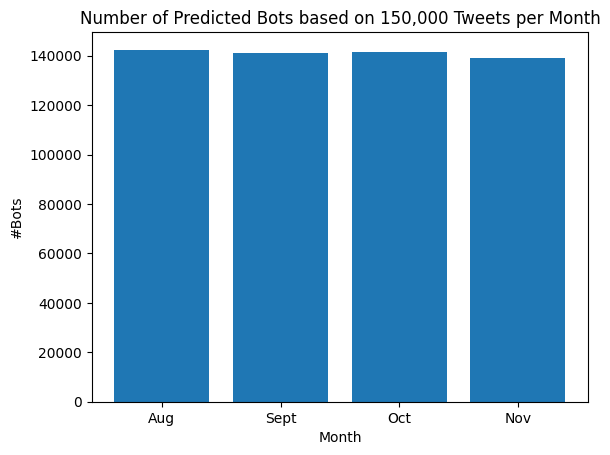

In [15]:
plt.bar(names, predictions)
plt.title('Number of Predicted Bots based on 150,000 Tweets per Month')
plt.xlabel('Month')
plt.ylabel('#Bots')
plt.show()